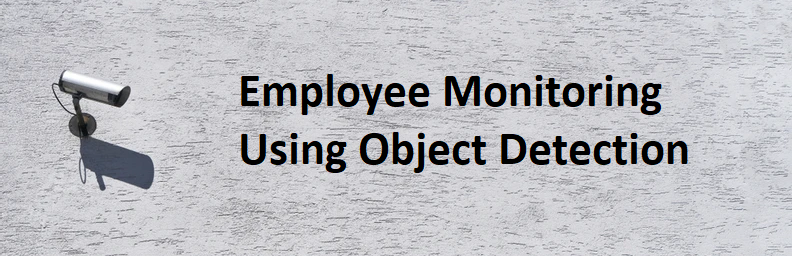

In [5]:
display(Image(filename="cover.png"))

## Highlights

- Employee monitoring to ensure fairness in tracking hours worked for employees
- Use of YOLO for counting and detecting persons in a room 
- Fine tuning of YOLO in a custom dataset to improve the result by 30%
- Use of Intersection over Union (IoU) as a threshold to determine if the station is taken or vacant
- Use of image processing techniques and use of pytesseract to perform OCR to get the time of the cctv camera

## Introduction

<p style="text-align:justify">Since pandemic is finally softening and nearing its end. Many companies are returning to office. However, there are some forgotten problems that we encounter as we stay in the office. As an employee, overtime hours is usually not being reflected in our salary because we were not able to track and justify on how long we haved worked in a day. On the other hand, as an employer, we are not sure how long an employee really work in a day specially when the company supports flexible schedule. Some employee could easily cheat their time which happened to our small business before. This project aims to answer <b>How might we ensure fairness in tracking hours worked for employees?</b></p>
<p style="text-align:justify">The solution that I implemented in this project is to use deep learning techniques to detect an employee and monitor the time the employee is seated in its station. An additional feature in this project is to count the number of person inside the office. To be able to track if there are some violations on social distancing.</p>

In [3]:
# python standard libraries
import os
import time
import glob
import re
import shutil
import pickle
from datetime import datetime, timedelta
from base64 import b64decode, b64encode

# google colab/notebook libraries
from IPython.display import display, Javascript, Image
from IPython.display import Video
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow

# external libraries
import cv2
import numpy as np
import PIL
import io
import html
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.morphology import erosion

# define color constants
person_color = (220, 155, 58)
vacant_color = (0, 0, 200)
taken_color = (0, 200, 0)
station_color = (0, 100, 0)

# constant coordinates
coordinates = {
    'station_1' : {'x1':1600, 'x2':1800, 
                   'y1':575, 'y2':780},
    'station_2' : {'x1':1287, 'x2':1472, 
                   'y1':310, 'y2':425},               
    'station_3' : {'x1':1145, 'x2':1287, 
                   'y1':197, 'y2':268},
               
    'station_4' : {'x1':561, 'x2':764, 
                   'y1':424, 'y2':578}
}

coordinates_ocr= [(1256, 39), (1885, 101)]

%matplotlib inline

In [1]:
from IPython.display import HTML
from IPython.display import Image

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<style>
.output_png {
    display: table-cell;
    text-align: center;
    horizontal-align: middle;
    vertical-align: middle;
    margin:auto;
}

tbody, thead {
    margin-left:100px;
}

</style>
<form action="javascript:code_toggle()"><input type="submit"
value="Click here to toggle on/off the raw code."></form>''')

In [2]:
# install if working on colab
!sudo apt install tesseract-ocr
!pip -qq install pytesseract

# import and install separately to avoid dependency issues later
import pytesseract

In [ ]:
# clone darknet repo if you are using original repository
!git clone https://github.com/AlexeyAB/darknet

In [1]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# copy whole dataset
!cp /content/drive/MyDrive/MSDS/ML3/final_project/XVR_ch5_main*.mp4 /content/

# clone of darknet github, extracted dataset, configurations, and custom weights
!cp /content/drive/MyDrive/MSDS/ML3/final_project/darknet_best.zip /content/

# trained weights from custom dataset
!cp /content/drive/MyDrive/MSDS/ML3/final_project/yolov4-obj_best.weights /content/

# unzip darknet directory 
!unzip -qq darknet_best.zip

# clone original darknet repo (use if you want default settings)
!git clone https://github.com/AlexeyAB/darknet

# change makefile to have GPU, OPENCV and LIBSO enabled
%cd /content/darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

# make darknet (builds darknet so that you can then use the darknet.py file 
# and have its dependencies)
!make

<h2> Exploratory Data Analysis </h2>

<p style="text-align:justify">Since it is just a single camera each of the frames would have the same size and channels. For exploratory data analysis, let us check the dimesions of one frame of the CCTV feed.</p>  

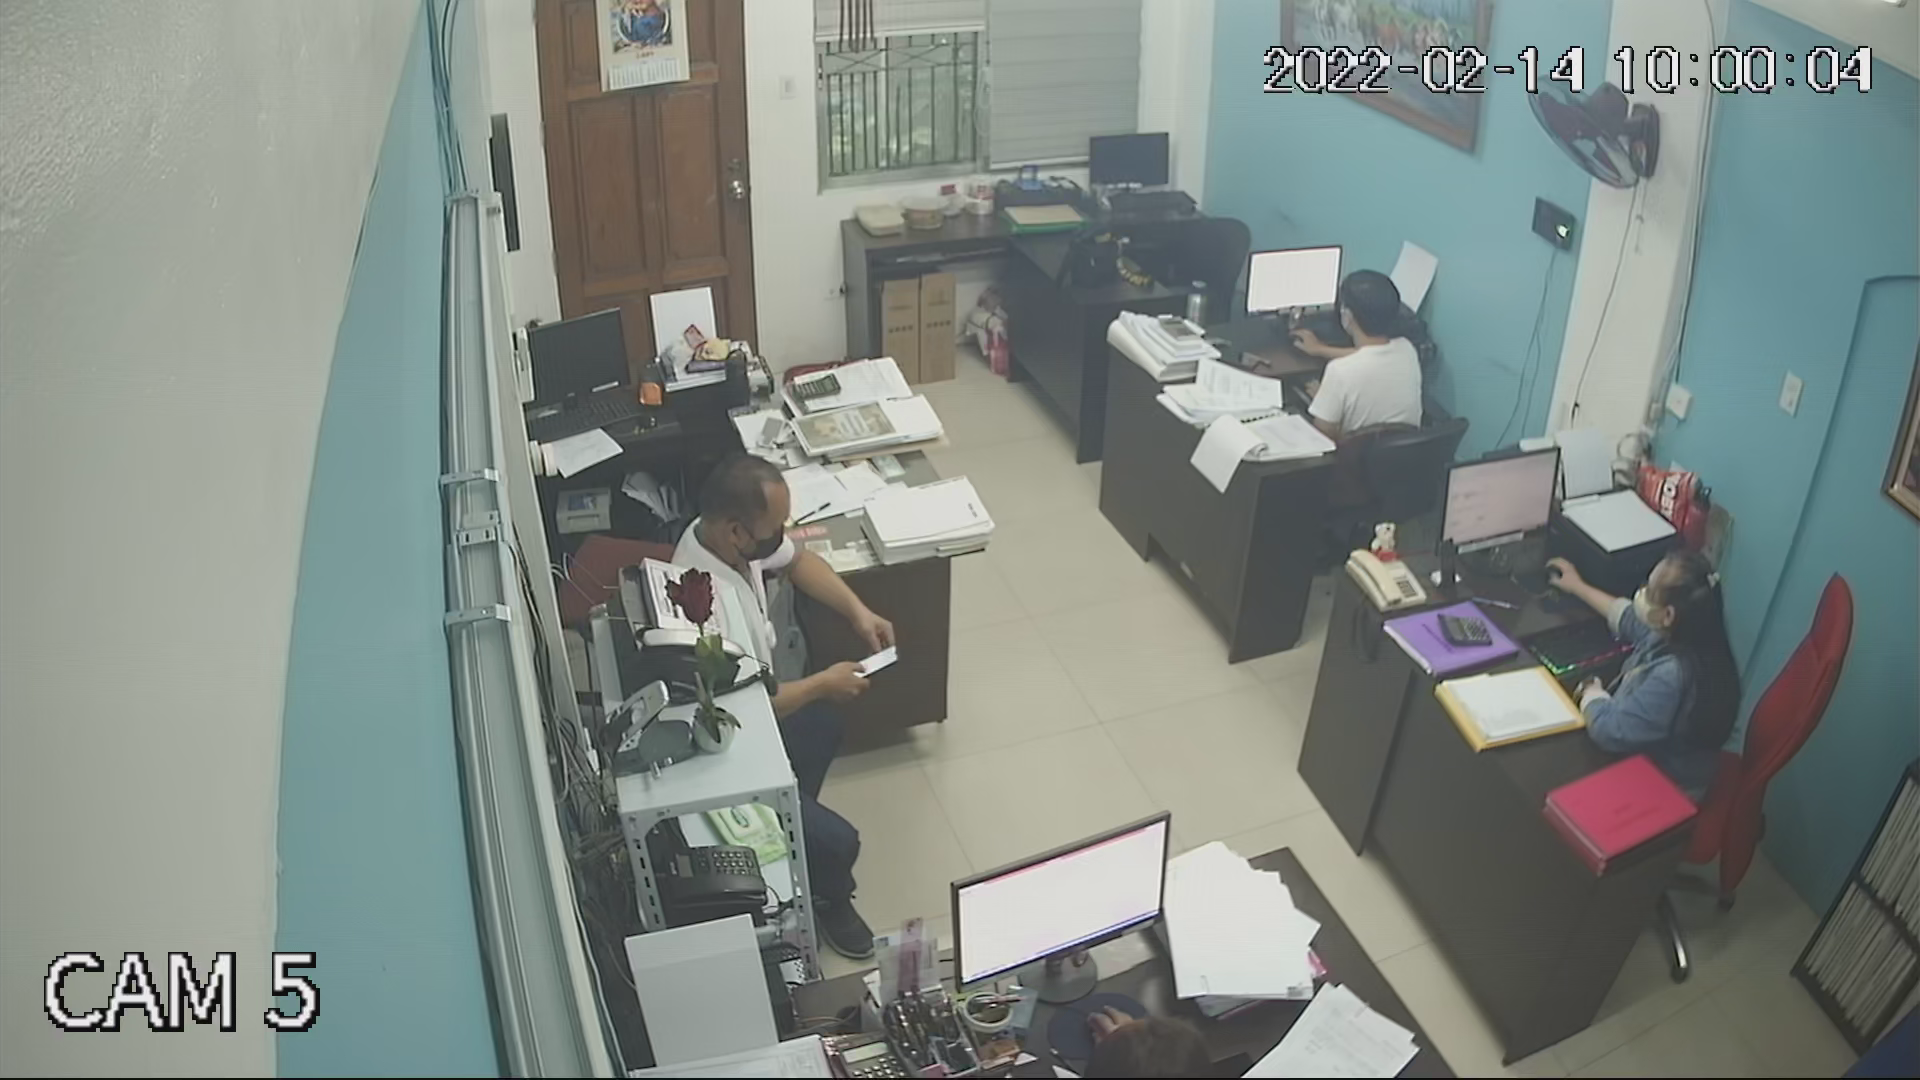

In [ ]:
# print sample image 
vidcap = cv2.VideoCapture('../XVR_ch5_main_20220214100004_20220214110005.mp4')
success,frame = vidcap.read()
cv2_imshow(frame)

The frame have dimensions of:

In [ ]:
# Get dimensions of image
width, height, channels = frame.shape
print(f'width: {width}')
print(f'height: {height}')
print(f'channels: {channels}')

width: 1080
height: 1920
channels: 3


## Methodology

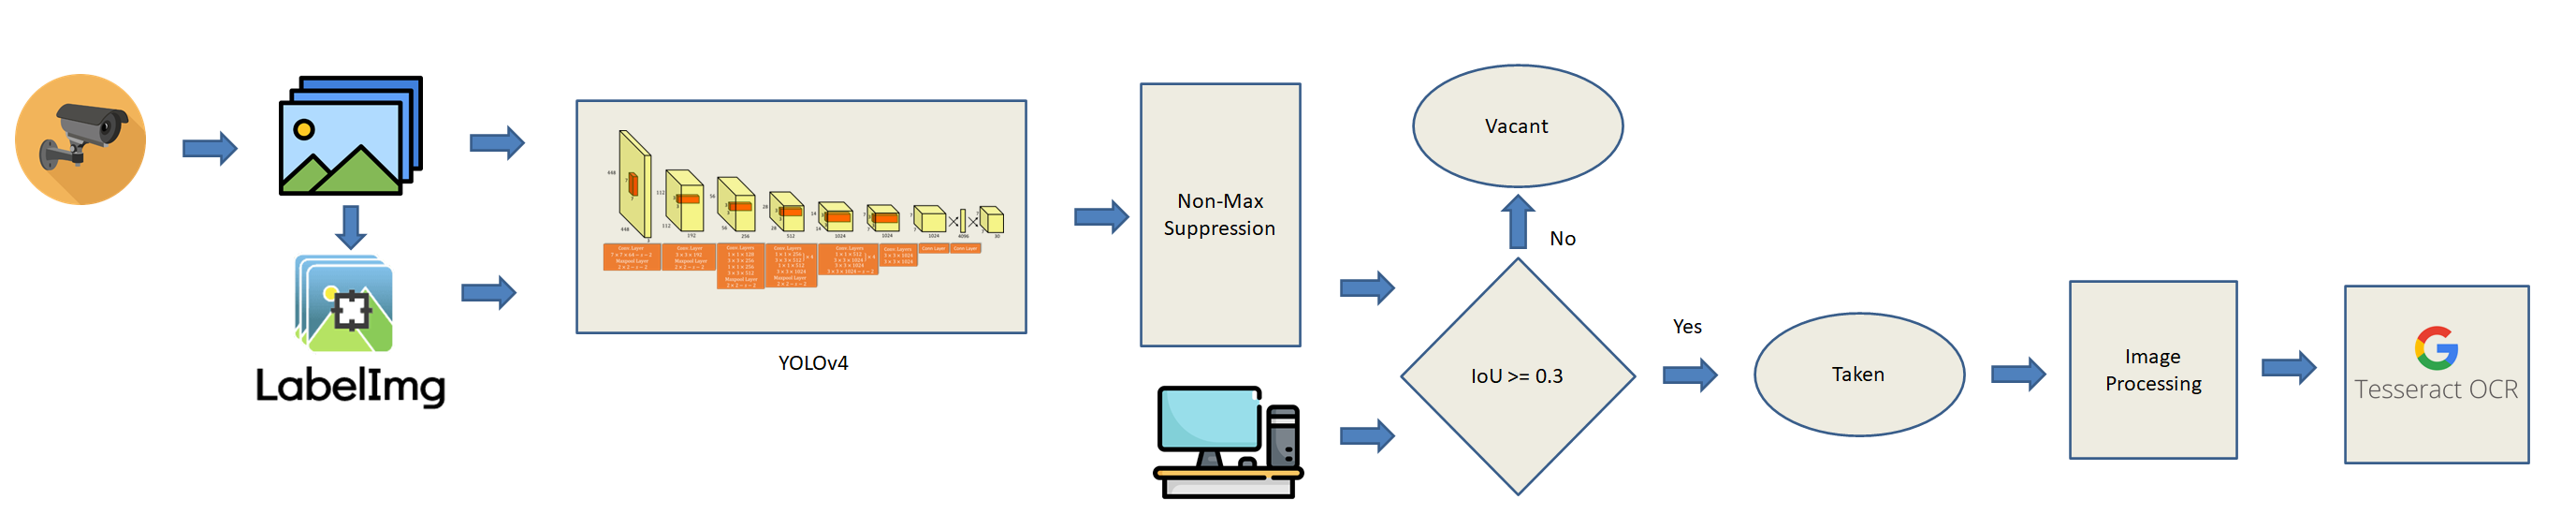

In [6]:
display(Image(filename="methodology.png"))

<b>a.) Dataset</b>
<p style="text-align:justify">The dataset used for this project is a personal video surveillance of our small business with total length of 1 hour in February 14.</p>

<b>b.) Extract images</b>
<p style="text-align:justify">Extracted 200 sample images to be used for training and validation set.</p>

<b>c.) Fine tune YOLOv4 model</b>
<p style="text-align:justify">Performed transfer learning using pretrained weights trained on COCO dataset and fine tune using custom dataset.</p>

<b>d.) Perform non-max suppression</b>
<p style="text-align:justify">Performed non-max suppression to remove multiple bounding boxes in a single object and get the maximum confidence among those bounding boxes that overlaps.</p>

<b>e.) Set-up work station</b>
<p style="text-align:justify">Set up work station to get and create a rule based on IoU of the detected person and the workstation to identify what are the stations that are taken and vacant.</p>

<b>f.) Compute for the time of the employee in work station</b>
<p style="text-align:justify">Used the information provided by the DVR which can be found on the upper right of the image and performed image processing techniques and optical character recognition to parse the image to a datetime python object.</p>

## Results and Discussion

<h2>i. Pre trained YOLO on COCO dataset</h2>

<p style="text-align:justify">YOLO has pre trained model on COCO dataset which could classify <a href="https://gist.github.com/AruniRC/7b3dadd004da04c80198557db5da4bda">80 objects</a>. <a href="https://cocodataset.org/#home">COCO</a> dataset is a large scale object detection, segmentation, and captioning of over 330k images. One of the objects that the YOLO trained on this dataset could classify is person which is what we need for this study. Let us try to use if it would work well on our dataset.</p>

In [6]:
# use if you want to use default settings
# get bthe scaled yolov4 weights file that is pre-trained to detect 80 classes (objects) from shared google drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

In [ ]:
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
    darknet_image = make_image(width, height, 3)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

    # get image ratios to convert bounding boxes to proper size
    img_height, img_width, _ = img.shape
    width_ratio = img_width/width
    height_ratio = img_height/height

    # run model on darknet style image to get detections
    copy_image_from_bytes(darknet_image, img_resized.tobytes())
    detections = detect_image(network, class_names, darknet_image)
    free_image(darknet_image)
    return detections, width_ratio, height_ratio

In [ ]:
# evaluate in validation set
%cd /content/darknet
!./darknet detector map data/obj.data cfg/yolov4-csp.cfg ../yolov4-csp.weights -points 0

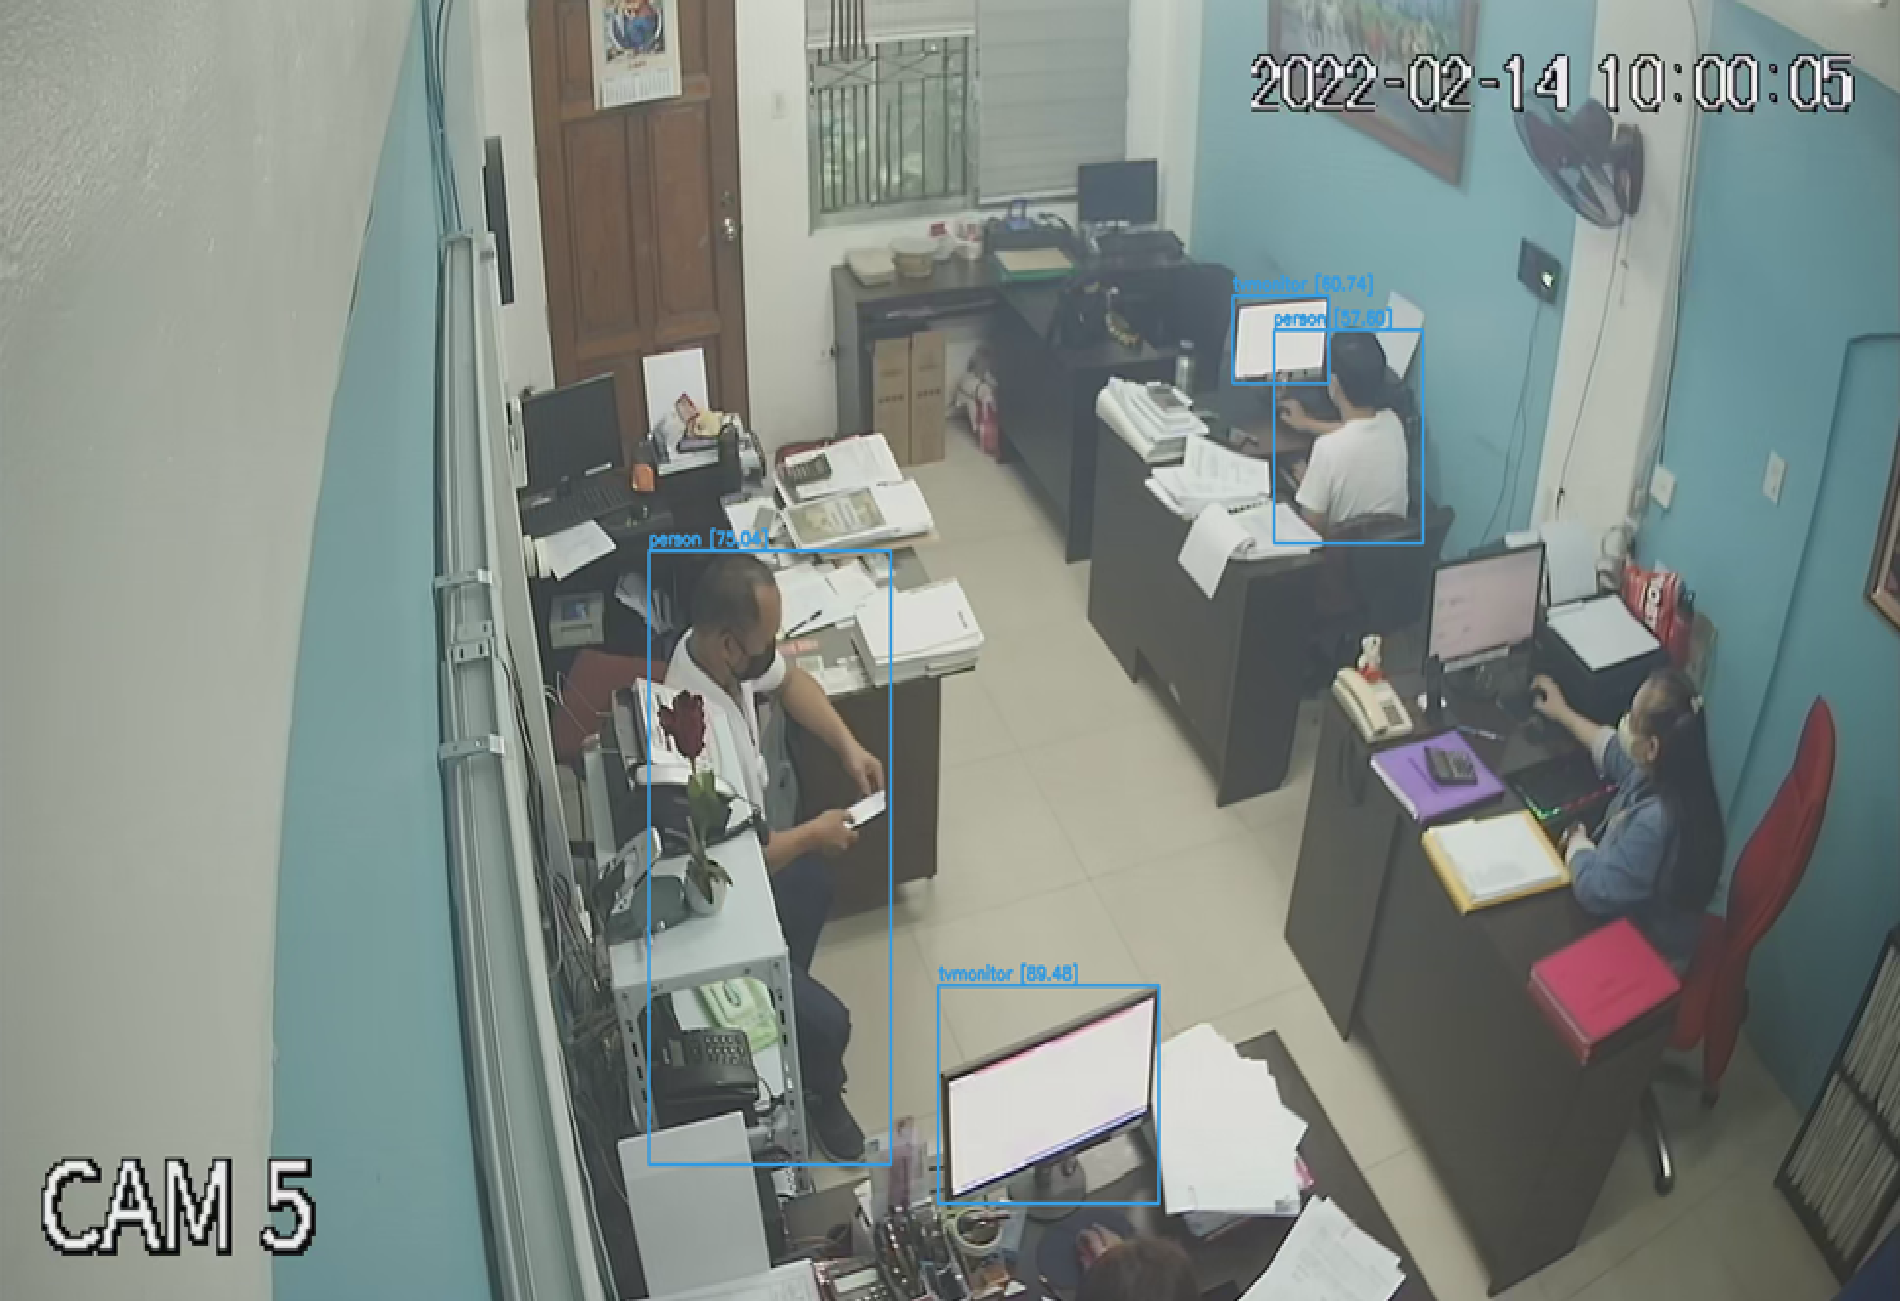

In [4]:
display(Image(filename="../pretrained.png"))

<p style="text-align:justify">It turns out that for some of the frames it would perfectly classify the person in the image. However, there are some frames that the model misclassify the person like as we can see in the lower right of the figure. Additionally, there are sometimes multiple bounding boxes on a single object and some objects that are not needed in this project are being classified like tv monitor. Although the model is trained on thousand of images, it was not really trained on this type of environment and probably not to all angles of a  person. </p>

## ii. Train YOLO on custom dataset

<p style="text-align:justify">To remedy the issues found in using pretrained model on COCO dataset, we can perform training on custom dataset. The detailed explanation on how to train your YOLO on custom dataset can be found in their <a href="https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects">documentation</a>.</p>

<h3>a. Extract custom dataset </h3>

<p style="text-align:justify">Training YOLO on custom dataset would require images, so we need to transform our video and sample it into images. <a href="https://labelstud.io/blog/Quickly-Create-Datasets-for-Training-YOLO-Object-Detection.html">50 to 100</a> images are usually enough to train a single object but for this project I sampled the data into 200 images to ensure more correctness of the data.</p>


In [ ]:
# extract data from video to 700 sampled images
cap = cv2.VideoCapture('XVR_ch5_main_20220214100004_20220214110005.mp4')
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
img_array =[]
counter = 0
image_count = 0
while ret:
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    if counter % int(length/700) == 0:
        fname = f'{image_count}.jpg'
        image_count += 1
        cv2.imwrite(fname, frame)
        
    counter += 1
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

<h3>b. Manually label person in custom dataset </h3>

<p style="text-align:justify">Now that we have our 200 images, we need to manually label the images in a format expected by the YOLO algorithm which is <code>{object-class} {x_center} {y_center} {width} {height}</code>. I used <a href="https://github.com/tzutalin/labelImg">LabelImg</a> to manually label my data into bounding boxes. It will produce text files of bounding boxes with the same filename as the image file and a text file that contains the class names. We then split the data into train and 10 percent validation set.</p>

In [ ]:
# copy txt and jpg data to a directory
fnames = glob.glob('data/*.txt')

for fname in fnames:
    fname_target = fname.replace('data', 'train')
    shutil.copyfile(fname, fname_target)
    if 'classes' in fname:
        continue
    else:
        image_fname = fname.replace('txt', 'jpg')
        image_target = image_fname.replace('data', 'train')
        shutil.copyfile(image_fname, image_target)
        
# create train and test data
# Percentage of images to be used for the test set
percentage_test = 10;

# Create and/or truncate train.txt and test.txt
file_train = open('./data/train.txt', 'w')
file_test = open('./data/test.txt', 'w')

# Populate train.txt and test.txt
counter = 1
index_test = round(100 / percentage_test)
for pathAndFilename in glob.iglob(os.path.join(os.getcwd(), "*.jpg")):
    title, ext = os.path.splitext(os.path.basename(pathAndFilename))

    if counter == index_test:
        counter = 1
        file_test.write("data/obj" + "/" + title + '.jpg' + "\n")
    else:
        file_train.write("data/obj" + "/" + title + '.jpg' + "\n")
        counter = counter + 1

file_train.close()
file_test.close()

<h3>c. Train the model</h3>

<p style="text-align:justify">The model training can be performed by using the <code>detector train</code> command which expects at least three parameters: data, configurations, and initial weights. Initially I used <code>yolov4.conv.137</code> as my pre trained weights which is trained in COCO dataset. Then, I retrained my weights to further improve the results. Overall it took me about six hours of training to get a good result.</p>

In [ ]:
# train by transfer learning from weights trained on coco dataset by darknet
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg yolov4.conv.137 -dont_show -map

In [ ]:
# continue training model by transfer learning from weights trained on custom dataset
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg  backup/yolov4-obj_last.weights -dont_show -map

In [ ]:
# backup saved weights
!cp backup/yolov4-obj_1000.weights /content/drive/MyDrive/MSDS/ML3/final_project/yolov4-obj_1000.weights
!cp backup/yolov4-obj_1000.weights /content/drive/MyDrive/MSDS/ML3/final_project/yolov4-obj_best.weights
!cp backup/yolov4-obj_1000.weights /content/drive/MyDrive/MSDS/ML3/final_project/yolov4-obj_last.weights

# copy mean average precision per epoch
!cp chart.png /content/drive/MyDrive/MSDS/ML3/final_project/chart_trained.png

<h3>d. Perform Non-Max Suppression</h3>

<p style="text-align:justify">The non max supression created by <a href="https://github.com/AlexeyAB/darknet/blob/master/darknet.py">darknet</a> prioritizes the bottom right bounding box and removes the overlap. I have updated the code of darknet to get the maximum confidence of the bounding boxes and remove the overlap. The solution could be slower than darknet implementation but it yielded into better accuracy which is more important in this project. I chose 65% threshold for the non-max suppression as it provided optimal result.</p>

In [ ]:
def non_max_suppression_fast(detections, overlap_thresh):
    """ modified non max suppression from darknet to get the overlap
        with max confidence
    
    Parameters
    ==========
    detections       :     tuple
                           class_name, confidence, and coordinates
    overlap_thresh   :     float
                           IOU threshold
    
    Returns
    ==========
    non_max_suppression_fast   :   tuple
                                   detections without high overlap
    """
    boxes = []
    confs = []

    for detection in detections:
        class_name, conf, (x, y, w, h) = detection
        x1 = x - w / 2
        y1 = y - h / 2
        x2 = x + w / 2
        y2 = y + h / 2
        boxes.append(np.array([x1, y1, x2, y2]))
        confs.append(conf)
   
    boxes_array = np.array(boxes)

    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes_array[:, 0]
    y1 = boxes_array[:, 1]
    x2 = boxes_array[:, 2]
    y2 = boxes_array[:, 3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    confs = np.array(confs)
    # keep looping while some indexes still remain in the indexes
    # list

    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # choose the highest confidence among overlaps
        overlap_args = np.where(overlap > overlap_thresh)[0]
        overlap_indices = idxs[overlap_args].tolist() + [i]
        confidence_list = confs[idxs[overlap_args]].tolist() + [confs[i]]
        confidence_list = list(map(float, confidence_list))
        highest_confidence = np.argmax(confidence_list)
        pick.append(overlap_indices[highest_confidence])

        # delete indices that overlaps
        idxs = np.delete(idxs, np.concatenate(([last], overlap_args)))

    return [detections[i] for i in pick]

<h3>e. Inference custom YOLO </h3>

<p style="text-align:justify">Now that we have trained our custom YOLO model and created a custom non-max suppression, we can now try if the model would work on a test set. The average precision increased from 69% trained on coco dataset to 98% in our custom dataset. You can evaluate using mean average precision of the object. It can be calculated by adjusting the threshold of confidence and get the average precision score on 50% IoU score. It can be calculated by using <code>detector map</code> command of YOLOv4 repository.</p>

In [7]:
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
(network, 
 class_names, 
 class_colors) = load_network("cfg/yolov4-obj.cfg", 
                              "data/obj.data", 
                              "backup/yolov4-obj_best.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
    """ darknet helper function to get detections, width and height ratio

    Parameters
    ==========
    img           :    np.array
                       image file
    width         :    int
                       width
    height        :    int
                       height
    
    Returns
    =========
    darknet_helper  : tuple
                      tuple of detections, width and height ratio
    """
    darknet_image = make_image(width, height, 3)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

    # get image ratios to convert bounding boxes to proper size
    img_height, img_width, _ = img.shape
    width_ratio = img_width/width
    height_ratio = img_height/height

    # run model on darknet style image to get detections
    copy_image_from_bytes(darknet_image, img_resized.tobytes())
    detections = detect_image(network, class_names, darknet_image)
    free_image(darknet_image)
    return detections, width_ratio, height_ratio

In [8]:
# run custom yolo on a sample image 
vidcap = cv2.VideoCapture('../XVR_ch5_main_20220214100004_20220214110005.mp4')

for i in range(15):
    success,frame = vidcap.read()

# get the predicted detections of the trained custom yolo
detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

# apply non max suppression to eliminate multiple predictions
# on same person
detections = non_max_suppression_fast(detections, 0.65)

for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = (int(left * width_ratio), int(top * height_ratio), 
    int(right * width_ratio), int(bottom * height_ratio))
    cv2.rectangle(frame, (left, top), (right, bottom), person_color, 2)
    cv2.putText(frame, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    person_color, 2)

cv2_imshow(frame)

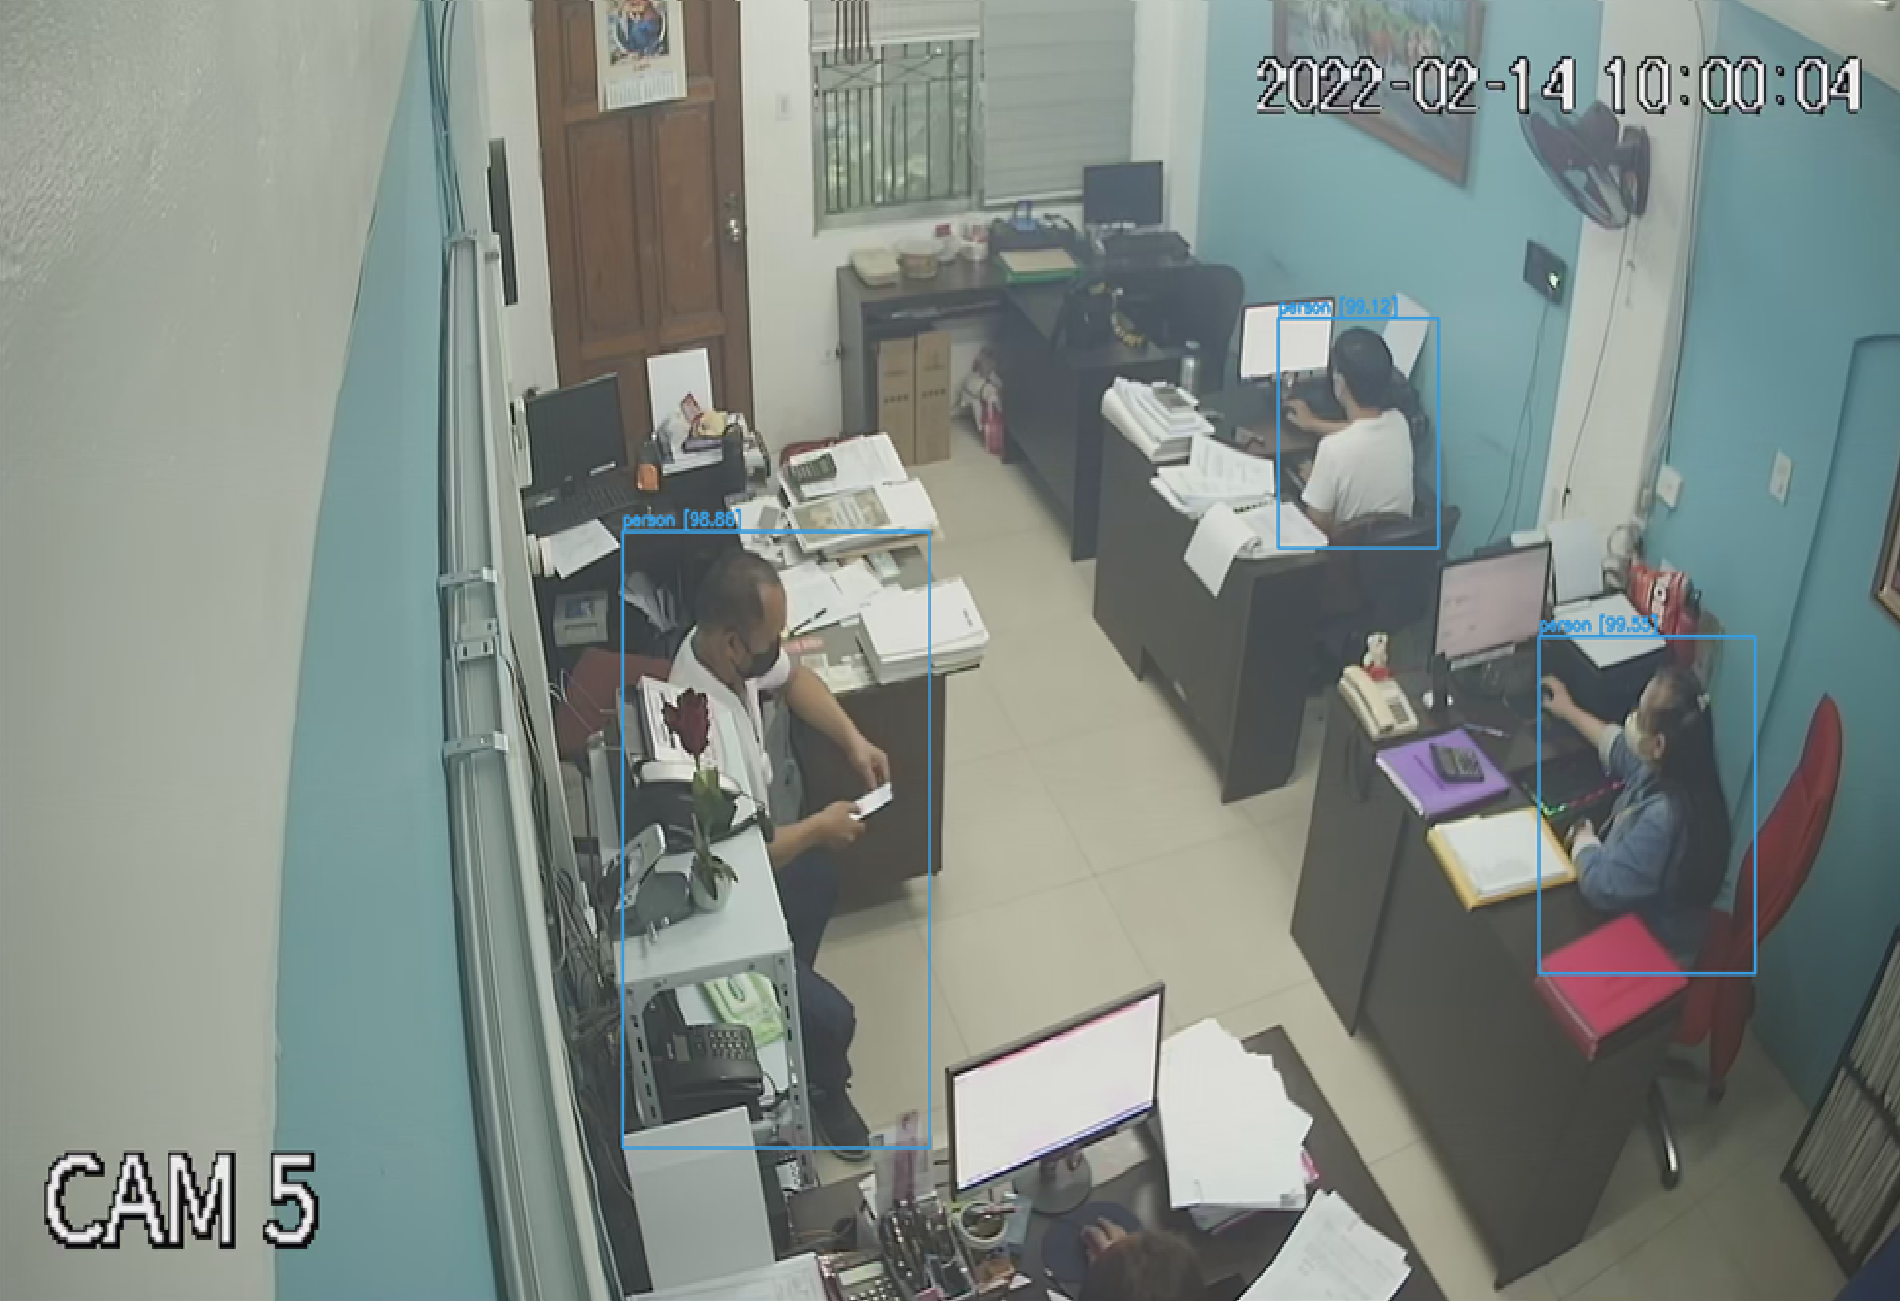

In [5]:
display(Image(filename="../trained.png"))

In [ ]:
# evaluate in validation set
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg backup/yolov4-obj_best.weights -points 0

<h2>iii. Set up work station area</h2>

<p style="text-align:justify">We now get the coordinates of the four work stations. I used paint to manually get the coordinates of each of the stations and plotted inte figure below.</p>

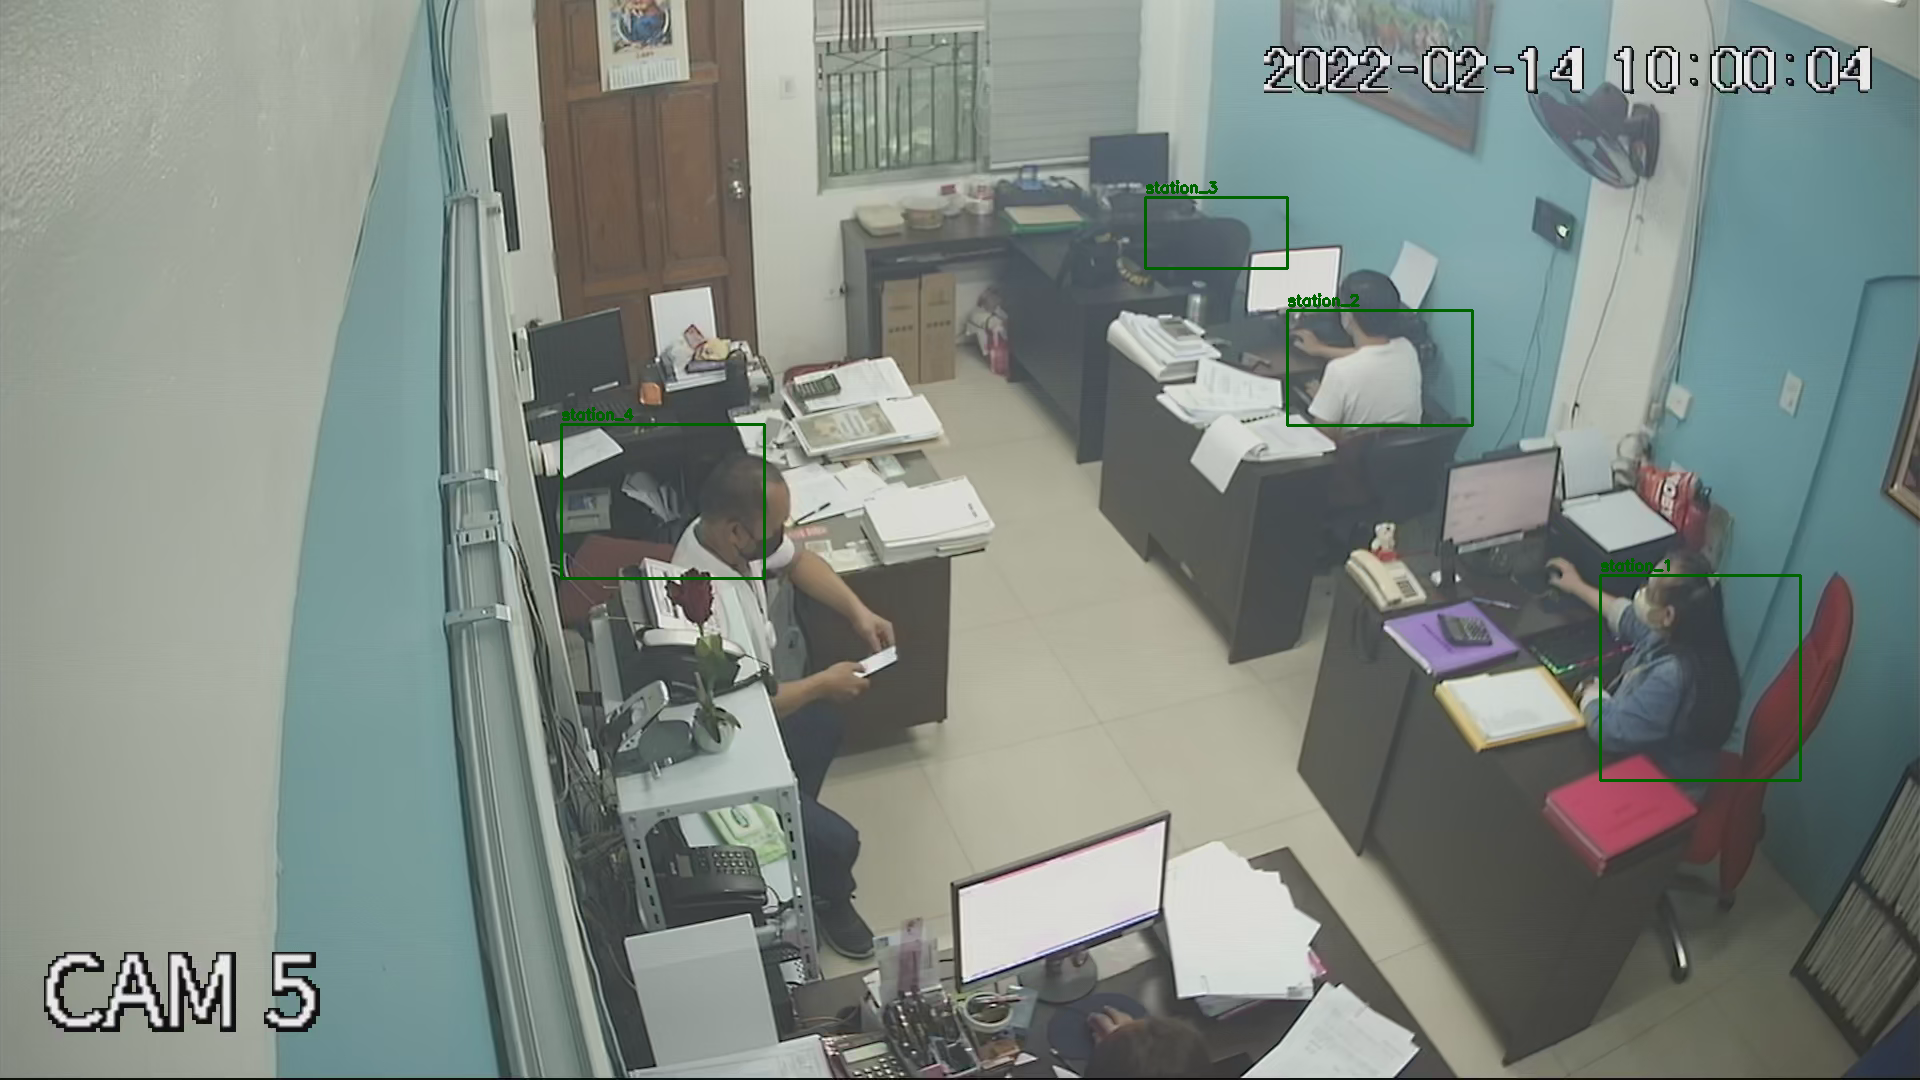

In [ ]:
# run custom yolo on a sample image 
vidcap = cv2.VideoCapture('/content/XVR_ch5_main_20220214100004_20220214110005.mp4')
success,frame = vidcap.read()


for stations, coordinate in coordinates.items():
    cv2.rectangle(frame, (coordinate['x1'], coordinate['y1']), 
                    (coordinate['x2'], coordinate['y2']), station_color, 2)
    cv2.putText(frame, f"{stations}",
                (coordinate['x1'], coordinate['y1'] - 5), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                station_color, 2)

cv2_imshow(frame)

<h2>iv. Integrate Custom YOLO on work stations</h2>

<p style="text-align:justify">To integrate work stations in our custom network, we need to set up a rule to determine if the work station is taken or vacant. I used the Intersect Over Union (IoU) of 0.3 as a threshold if they overlap with the person to determine if the station is taken. </p>

In [ ]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    
    return iou 

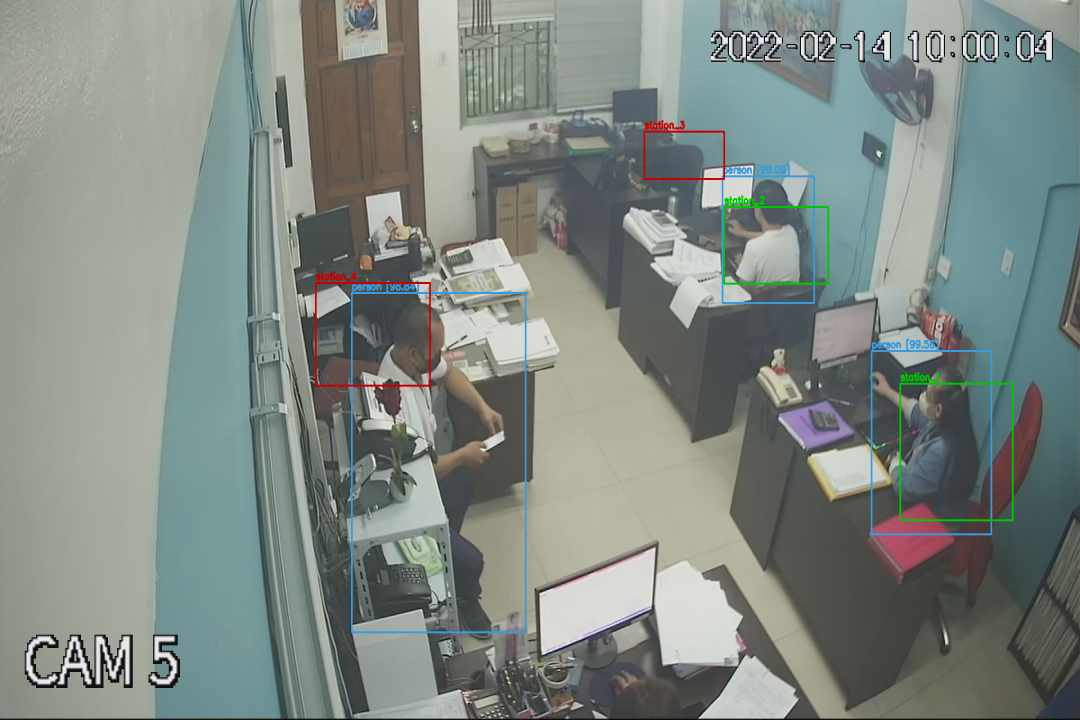

In [ ]:
# run custom yolo on a sample image 
vidcap = cv2.VideoCapture('/content/XVR_ch5_main_20220214100004_20220214110005.mp4')
success,frame = vidcap.read()

# get the predicted detections of the trained custom yolo
detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

# apply non max suppression to eliminate multiple predictions
# on same person
detections = non_max_suppression_fast(detections, 0.65)
detections_bb = []
for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = (int(left * width_ratio), 
                                int(top * height_ratio), 
                                int(right * width_ratio), 
                                int(bottom * height_ratio))
    
    cv2.rectangle(frame, (left, top), (right, bottom), person_color, 2)
    cv2.putText(frame, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    person_color, 2)

    detections_bb.append({
        'x1' : left,
        'y1' : top,
        'x2' : right,
        'y2' : bottom
    })

thresh = 0.3
for stations, coordinate in coordinates.items():
    taken = False
    for detection in detections_bb:
        iou = get_iou(coordinate, detection)
        if iou >= thresh:
            taken = True
            break
    color = taken_color if taken else vacant_color
        
    cv2.rectangle(frame, (coordinate['x1'], coordinate['y1']), 
                    (coordinate['x2'], coordinate['y2']), color, 2)
    
    cv2.putText(frame, f"{stations}",
                (coordinate['x1'], coordinate['y1'] - 5), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                color, 2)
frame = cv2.resize(frame, (1080, 720), 
                    interpolation=cv2.INTER_AREA)

cv2_imshow(frame)

<h2>v. Extract datetime information</h2>

<p style="text-align:justify">To get the time the employee stays in its work station, we can perform it in two ways: We can use the information of the image presented by the DVR which can be seen in the upper right of the image, or used the information of the camera by knowing the  frames per second of the camera. In this project I used both method but the former is more appropriate since based on my experience, CCTV cameras are often changed compared to the DVR. Cameras could have multiple frames per second, and using that information could yield to incorrect classification of time. Hence, extracting the information produced by the DVR would have longer usability of the model that we would create. Here is the sample of the original image:</p>

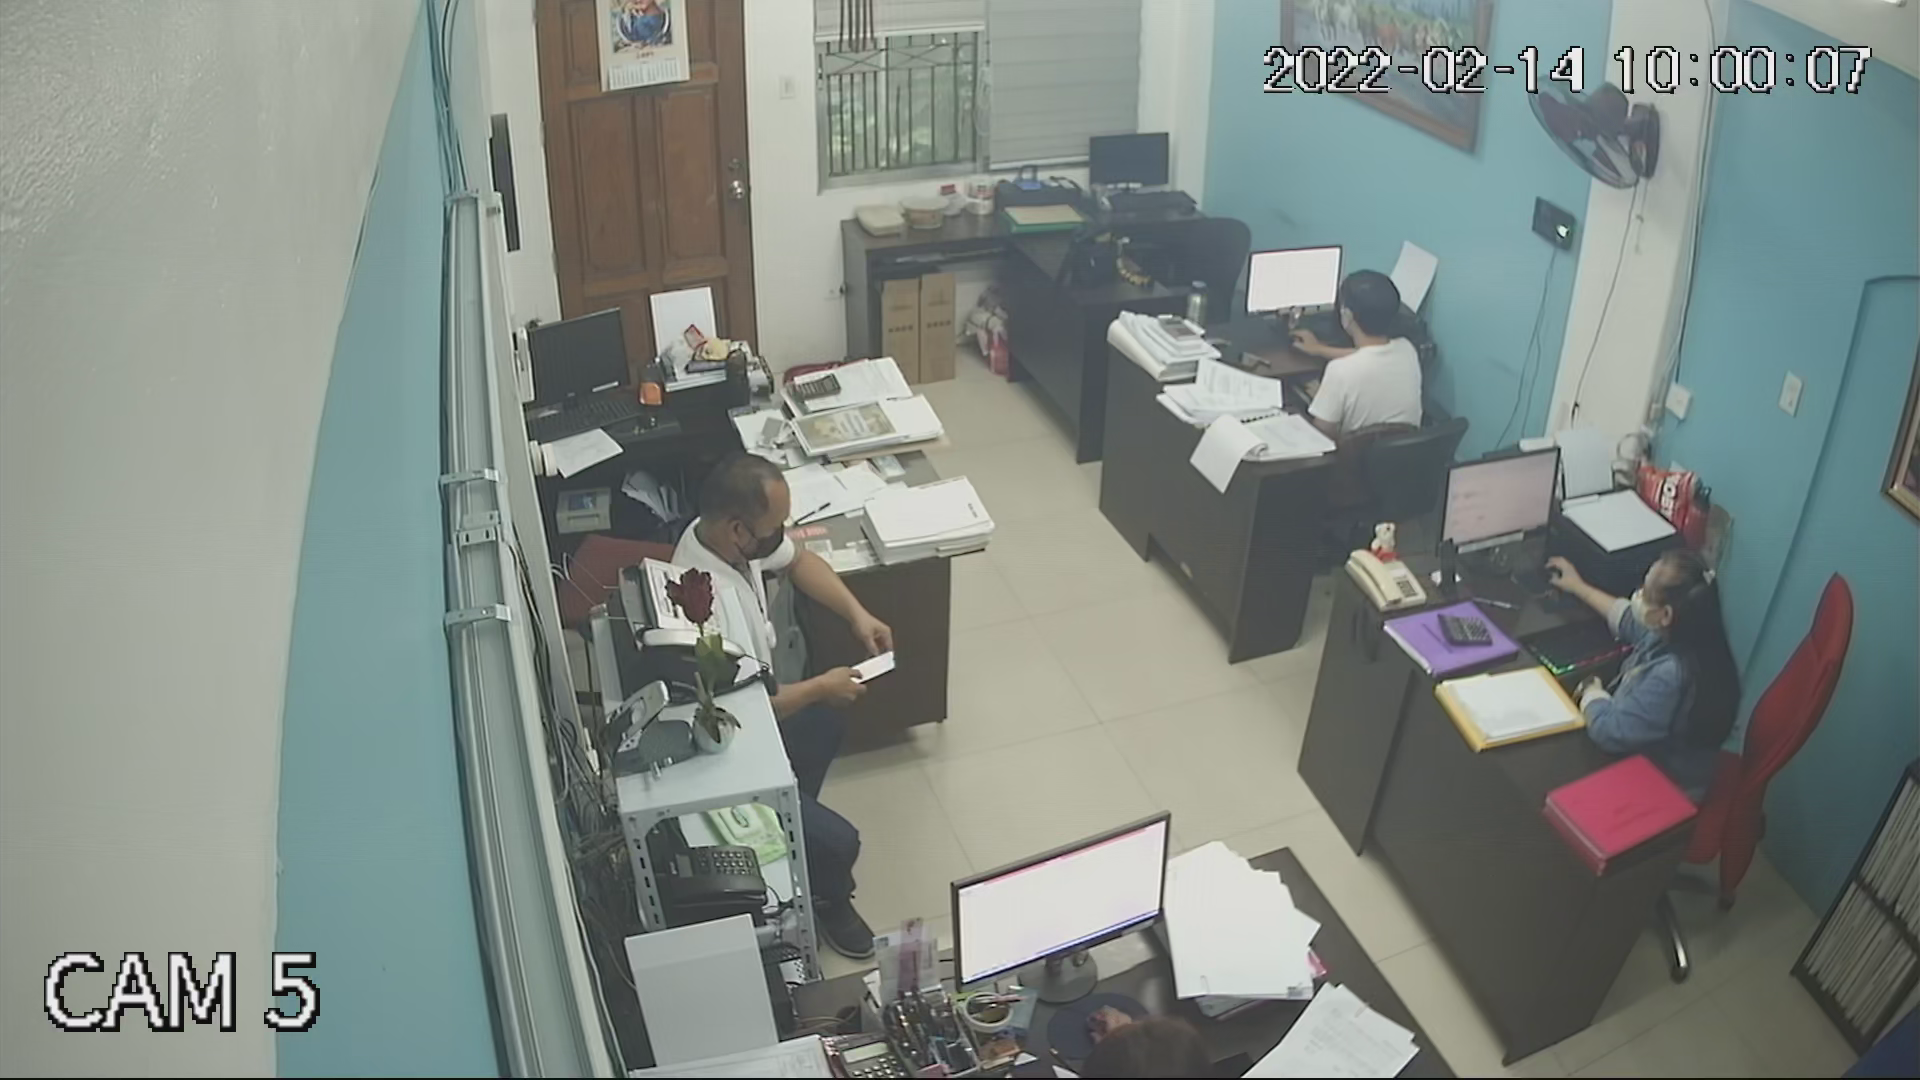

In [ ]:
if not imgs:
    vidcap = cv2.VideoCapture('../XVR_ch5_main_20220214100004_20220214110005.mp4')
    success,imgs = vidcap.read()

cv2_imshow(imgs[1])

### a. Datetime information using OCR

<p style="text-align:justify">First, I performed image preprocessing in order for the OCR model to understand the text in the image more accurately. The image processing techniques performed are extract the image to get the area with the date time only, convert the image into BGR to Gray, adjust the contrast and brightness to make the background brighter before thresholding, perform adaptive thresholding to remove the background, and lasty use morphological operations such as multiple erosion to make the text bolder.</p>

In [13]:
def multi_ero(im, num):
    """ Perform multiple erosion on the image

    Parameters
    ==========
    im        :     np.array
                    image file
    num       :     int
                    number of times to apply erosion
    """
    for i in range(num):
        im = erosion(im)
    return im

imgs = []
# get images for testing 
vidcap = cv2.VideoCapture('../XVR_ch5_main_20220214100004_20220214110005.mp4')
success,frame = vidcap.read()
for i in tqdm(range(8000)):
    # Capture frame-by-frame
    success, frame = vidcap.read()
    if not i % 50: 
        if frame is not None:
            imgs.append(frame)
        else:
            pass
invalid = []
valid = []
datetime_clean = []


for img in tqdm(imgs):
    img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)

    contrast = 3
    contrast = max(contrast, 1.0); contrast = min(contrast, 3.0)

    brightness = 60
    brightness = max(brightness, 0.0); brightness = min(brightness, 100.0)

    img = np.clip(contrast * img.astype('float32') 
                        + brightness, 0.0, 255.0)

    img = img.astype('uint8')

    img = cv2.adaptiveThreshold(img,
                                255,
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                cv2.THRESH_BINARY,
                                21, 2)

    img = img[coordinates_ocr[0][1]:coordinates_ocr[1][1], 
              coordinates_ocr[0][0]:coordinates_ocr[1][0]]

    img = multi_ero(img, 2)
    datetime_clean.append(img)
    text = pytesseract.image_to_string(img, lang='eng', 
            config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789:-')
    
    time_format = r'[0-5]\d:[0-5]\d:[0-5]\d'
    date_format = r'\d{4}-(?:0\d|1[12])-(?:[0-2]\d|3[01])'
    datetime_format = date_format + time_format
    text = text.replace(' ', '')
    try:
        timestamp_string = re.sub('(\d{4}-(?:0\d|1[12])-(?:[0-2]\d|3[01]))', 
                                r'\1' + r' ', 
                                re.findall(datetime_format, text)[0])
    except:
        invalid.append(text)
        continue

    
    if len(text) != 20:
        invalid.append(text)
        
    else:
        valid.append(text)

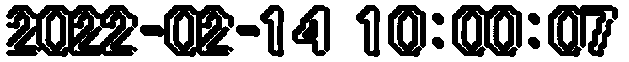

In [ ]:
cv2_imshow(datetime_clean[1])

<p style="text-align:justify">I used <a href="https://pypi.org/project/pytesseract/">Pytesseract</a> to read the text in the image and convert it to datetime object of python. Pytesseract is an optical character recognition (OCR) tool for python made by Google that uses Deep Learning and in particular LSTM to predict on the text of the image. I used the following configurations:<code>psm</code>=10 so that it it will classify per character, and <code>tessedit_char_whitelist=0123456789:-</code> so that the model would be forced to classify between these whitelist characters which are expected in our date and time element</p> 

In [ ]:
def get_ocr_datetime(img, contrast=3, brightness=60):
    """ get the datetime equivalent based on the image

    Parameters
    ==========
    img        :    np.array
                    image file
    contrast   :    int
                    contrast between 1-3
    brightness :    int 
                    brightness between 0-100

    Returns
    =========
    get_ocr_datetime  :   datetime.datetime
                          datetime equivalent of the cctv image
    """
    # convert to grayscale
    img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)

    contrast = max(contrast, 1.0)
    contrast = min(contrast, 3.0)
    
    brightness = max(brightness, 0.0) 
    brightness = min(brightness, 100.0)

    # clip image based on contrast and brightness provided
    img = np.clip(contrast * img.astype('float32') 
                        + brightness, 0.0, 255.0)

    img = img.astype('uint8')

    # perform adaptive thresholding
    img = cv2.adaptiveThreshold(img,
                              255,
                              cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                              cv2.THRESH_BINARY,
                              21, 2)

    # perform segmentation on the region of interest
    img = img[coordinates_ocr[0][1]:coordinates_ocr[1][1], 
              coordinates_ocr[0][0]:coordinates_ocr[1][0]]

    # perform multiple erosion
    img = multi_ero(img, 2)
    
    # get text using pytesseract 
    text = pytesseract.image_to_string(img, lang='eng', 
            config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789:-')
    
    # check validity of results
    time_format = r'[0-5]\d:[0-5]\d:[0-5]\d'
    date_format = r'\d{4}-(?:0\d|1[12])-(?:[0-2]\d|3[01])'
    datetime_format = date_format + time_format
    text = text.replace(' ', '')

    if len(text) == 20:
        text = '2022-02-14' + text[10:]
    
    try:
        timestamp_string = re.sub('(\d{4}-(?:0\d|1[12])-(?:[0-2]\d|3[01]))', 
                                r'\1' + r' ', 
                                re.findall(datetime_format, text)[0])
    except:
        return None
    
    return datetime.strptime(timestamp_string, "%Y-%m-%d %H:%M:%S")

In [ ]:
print(f'correct datetime format percentage: {len(valid)/len(imgs) * 100}')

correct datetime format percentage: 70.0


<p style="text-align:justify">I checked the format and found out that 70% of the results are correctly classified in a correct datetime format by the model. In particular, it experienced difficulties in classifying number eight when it is near six. However there are about 15 frames per second so there will be a lot of chance for the model to get the correct time. Here is a sample of the output of the pytesseract that is passed to be converted to Python datetime. </p>

In [3]:
get_ocr_datetime(imgs[1])

datetime.datetime(2022, 2, 14, 10, 0, 7)

### b. Datetime information using fps

<p style="text-align:justify">The camera that I am using is a 15 fps which is one of the standard of a CCTV. Using that information, we count the number of frames an employee is sitting on its station then for every 15 frames we count that as 1 second.</p>

<h2>VI. Integration of timer to workstation </h2>

<h3>a. OCR</h3>

In [ ]:
# initialize timer per station
# list definition:
# list[0] : total time in work station
# list[1] : last datetime 
# list[2] : debt
timer = {'station_' + str(i): [timedelta(0), None, False] for i in range(1,5)}

%cd /content/
cap = cv2.VideoCapture('XVR_ch5_main_20220214100004_20220214110005.mp4')
success,frame = cap.read()

width =  1600
height = 900
resize = True
img_array =[]
for i in tqdm(range(4500)):
    # Capture frame-by-frame
    ret, frame = cap.read()

    if i <= 2600:
        continue

    detections, width_ratio, height_ratio = darknet_helper(frame, 
                                                           width, 
                                                           height)
    detections = non_max_suppression_fast(detections, 0.65)
    detections_bb = []
    for label, confidence, bbox in detections:
        left, top, right, bottom = bbox2points(bbox)
        left, top, right, bottom = (int(left * width_ratio), 
                                    int(top * height_ratio), 
                                    int(right * width_ratio), 
                                    int(bottom * height_ratio))
        cv2.rectangle(frame, (left, top), (right, bottom), person_color, 2)
        cv2.putText(frame, "{} [{:.2f}]".format(label, float(confidence)),
                            (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                            person_color, 4)
        
        detections_bb.append({
                'x1' : left,
                'y1' : top,
                'x2' : right,
                'y2' : bottom
            })
    
    thresh = 0.3
    
    for stations, coordinate in coordinates.items():
        taken = False
        for detection in detections_bb:
            iou = get_iou(coordinate, detection)
            if iou >= thresh:
                taken = True
                break
        
        if taken or timer[stations][2]:
            ocr_time = get_ocr_datetime(frame)
            if ocr_time is None:
                timer[stations][2] = True
                continue
            else:
                timer[stations][2] = False
                if timer[stations][1] is None:
                    timer[stations][1] = ocr_time
                else:
                    if timer[stations][1] > ocr_time:
                        # invalid time
                        timer[stations][2] = True
                    elif (ocr_time - timer[stations][1]) <= timedelta(seconds=3):
                        timer[stations][0] += (ocr_time - timer[stations][1])
                        timer[stations][1] = ocr_time
                    else:
                        # invalid time
                        timer[stations][2] = True

        color = taken_color if taken else vacant_color
            
        cv2.rectangle(frame, (coordinate['x1'], coordinate['y1']), 
                        (coordinate['x2'], coordinate['y2']), color, 2)
        
        cv2.putText(frame, f"{stations} [{str(timer[stations][0])}]",
                    (coordinate['x1'], coordinate['y1'] - 5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    color, 2)

    if resize:
        frame = cv2.resize(frame, (width, height), 
                            interpolation=cv2.INTER_AREA)
    img_array.append(frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

### b. FPS

In [12]:
# initialize timer per station
# list definition:
# list[0] : total time in work station
# list[1] : number of frames in each work station
timer = {'station_' + str(i): [timedelta(0), 0] for i in range(1,5)}

%cd /content/
cap = cv2.VideoCapture('XVR_ch5_main_20220214100004_20220214110005.mp4')
success,frame = cap.read()

width =  1600
height = 900
resize = False
img_array =[]
for i in tqdm(range(4300)):
    # Capture frame-by-frame
    ret, frame = cap.read()

    if i <= 2600:
        continue

    detections, width_ratio, height_ratio = darknet_helper(frame, 
                                                           width, 
                                                           height)
    detections = non_max_suppression_fast(detections, 0.65)
    detections_bb = []
    for label, confidence, bbox in detections:
        left, top, right, bottom = bbox2points(bbox)
        left, top, right, bottom = (int(left * width_ratio), 
                                    int(top * height_ratio), 
                                    int(right * width_ratio), 
                                    int(bottom * height_ratio))
        cv2.rectangle(frame, (left, top), (right, bottom), person_color, 2)
        cv2.putText(frame, "{} [{:.2f}]".format(label, float(confidence)),
                            (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                            person_color, 4)
        
        detections_bb.append({
                'x1' : left,
                'y1' : top,
                'x2' : right,
                'y2' : bottom
            })
    
    thresh = 0.2
    
    for stations, coordinate in coordinates.items():
        taken = False
        for detection in detections_bb:
            iou = get_iou(coordinate, detection)
            if iou >= thresh:
                taken = True
                break
        
        if taken:
            timer[stations][1] += 1
            if timer[stations][1] % 15 == 0:
                timer[stations][1] = 0
                timer[stations][0] += timedelta(seconds=1)
              

        color = taken_color if taken else vacant_color
            
        cv2.rectangle(frame, (coordinate['x1'], coordinate['y1']), 
                        (coordinate['x2'], coordinate['y2']), color, 2)
        
        cv2.putText(frame, f"{stations} [{str(timer[stations][0])}]",
                    (coordinate['x1'], coordinate['y1'] - 5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    color, 2)
        
    count_person = len(detections_bb)
    cv2.rectangle(frame, (23, 26), 
                      (208, 63), (0,0,0), -1)
    
    cv2.putText(frame, f"Count of Person: {count_person:0>2}",
                    (23 + 5,26+ 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255,255, 255), 2)

    if resize:
        frame = cv2.resize(frame, (width, height), 
                            interpolation=cv2.INTER_AREA)
    img_array.append(frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

## VII. Save frames as Video

<p style="text-align:justify">Save frames as video as mp4 and compress it in order to be compatible with Google Colab. The demo video will be submitted separately so it will not blow up the size of the notebook.</p>

In [ ]:
cap = cv2.VideoCapture('resized_cctv_full.mp4')

img_array =[]
success = True
while success:
    success,frame = cap.read()
    # Capture frame-by-frame
    img_array.append(frame)

In [11]:
%cd /content/
fname = 'resized_cctv.mp4'
if not resize:
    width = 1920
    height = 1080
    
if any([True if fname in f else False for f in os.listdir()]):
    !rm resized_cctv.mp4

out = cv2.VideoWriter('/content/resized_cctv.mp4',
                      cv2.VideoWriter_fourcc(*'MP4V'), 
                      20, (1600, 900))

for i in tqdm(range(len(img_array))):
    out.write(img_array[i])
out.release()

In [10]:
%cd darknet

from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = "/content/resized_cctv_full.mp4"

# Compressed video path
compressed_path = "/content/resized_cctv_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=900 height=1600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


In [ ]:
!cp /content/resized_cctv.mp4 /content/drive/MyDrive/MSDS/ML3/final_project/resized_cctv_full_fast.mp4

## VIII. Final Output Demo

In [4]:
display(Video('outputs/resized_cctv_full_fast_cut.mov'))